<a href="https://colab.research.google.com/github/gabrielfernandorey/ITBA-NLP/blob/main/ITBA_nlp01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Practico NLP - Detección de Tópicos y clasificación
- ITBA 2024
- Alumno: Gabriel Rey
---

## Merged models

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np
from matplotlib import pyplot as plt
import os
import json
from datetime import datetime, date
from dateutil.parser import parse
from dotenv import load_dotenv

from NLP_tools import *

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from tqdm import tqdm

from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer

In [3]:
from opensearch_data_model import Topic, TopicKeyword, News, os_client, TOPIC_INDEX_NAME, NEWS_INDEX_NAME
from opensearch_io import *
from opensearchpy import helpers

from openai import OpenAI

### Inicializamos la base vectorial

In [4]:
init_opensearch()

El índice Topic ya existe. Saltando inicialización de base de datos.
El índice News ya existe. Saltando inicialización de base de datos.


### Path

In [5]:
load_dotenv()
PATH_REMOTO='/content/ITBA-NLP/data/'
PATH=os.environ.get('PATH_LOCAL', PATH_REMOTO)
PATH

'C:/Users/gabri/OneDrive/Machine Learning/Github/ITBA-NLP/data/'

In [6]:
if PATH == os.environ.get('PATH_LOCAL'):
    if os.environ.get('OPENAI_API_KEY'):
        client = OpenAI(api_key= os.environ.get('OPENAI_API_KEY'))
    else:
        client = None
    print(client)

### Cargamos noticias 
- Notas:
    - Se carga el segundo batch de noticias, luego de haber corrido al menos el primero y segundo batch con la notebook NLP_01_data
    - Se debe haber generado el primer modelo en NLP_02_model
    - Para cargar el segundo batch, se utiliza la fecha como identificador del lote

In [11]:
# Cargar batch de noticias ( a partir del segundo batch en adelante ) por fecha previamente preprocesado en NLP_01_data 
choice = "20240717"  
date_choice = choice[:4]+"-"+choice[4:6]+"-"+choice[6:8]
batch_news = get_news(date_choice)

if batch_news == []:
    print("No hay noticias a procesar")

id_data     = [reg[0] for reg in batch_news]
title_data  = [reg[1] for reg in batch_news]
news_data   = [reg[2] for reg in batch_news]
keywords    = [reg[3] for reg in batch_news]
entities    = [reg[4] for reg in batch_news]
created     = [reg[5] for reg in batch_news]

# Cargar vocabulario previamente procesado
with open(PATH+f'preproc_notebook/vocabulary_{choice}.json', 'r') as json_file:
    vocab = json.load(json_file)
len(vocab)

6201

### Preprocesar batch de noticias

In [12]:
SPANISH_STOPWORDS = list(pd.read_csv(PATH+'spanish_stop_words.csv' )['stopwords'].values)
SPANISH_STOPWORDS_SPECIAL = list(pd.read_csv(PATH+'spanish_stop_words_spec.csv' )['stopwords'].values)

clean_data = Cleaning_text()

proc_data = []
for data_in in tqdm(news_data):
    aux = clean_data.unicode(data_in)
    aux = clean_data.urls(aux)
    aux = clean_data.simbols(aux)
    aux = clean_data.escape_sequence(aux)
    aux = " ".join([ word for word in aux.split() if word.lower() not in SPANISH_STOPWORDS_SPECIAL])
    proc_data.append(aux)

100%|██████████| 1000/1000 [00:00<00:00, 1797.08it/s]


### Modelo para el batch

In [13]:
tfidf_vectorizer = TfidfVectorizer(
        tokenizer=None,
        max_df=0.9,
        min_df=0.1,
        ngram_range=(1, 2),
        vocabulary=vocab,
        # max_features=100_000
)
tfidf_vectorizer.fit(news_data)

# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
# Step 4 - Tokenize topics
vectorizer_model = tfidf_vectorizer
# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()
# Step 6 - (Optional) Fine-tune topic representations with a `bertopic.representation` model
# representation_model = KeyBERTInspired()

# All steps together
topic_model_2 = BERTopic(
  embedding_model=embedding_model,              # Step 1 - Extract embeddings
  umap_model=umap_model,                        # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,                  # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,            # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                    # Step 5 - Extract topic words
  # representation_model=representation_model,  # Step 6 - (Optional) Fine-tune topic represenations
  # language='multilingual',                    # This is not used if embedding_model is used.
  verbose=True,
  # calculate_probabilities=True
)

### Entrenamiento

In [14]:
# Entrenamiento
_, _ = topic_model_2.fit_transform(proc_data)

# No necesito generar topicos, ni probabilidades, ni embeddings del modelo 2, ya que vamos a fusionar modelos.

2024-08-29 14:20:00,886 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2024-08-29 14:21:37,463 - BERTopic - Embedding - Completed ✓
2024-08-29 14:21:37,465 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-08-29 14:21:48,654 - BERTopic - Dimensionality - Completed ✓
2024-08-29 14:21:48,655 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-08-29 14:21:48,688 - BERTopic - Cluster - Completed ✓
2024-08-29 14:21:48,691 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-08-29 14:21:49,235 - BERTopic - Representation - Completed ✓


### Merge de modelos

In [15]:
# Cargamos el modelo anterior
topic_model_1 = BERTopic.load(PATH+"modelos_notebook/bertopic_model_last")
print(f"Topicos anteriores: {len(set(topic_model_1.get_topics().keys()))-1}")

Topicos anteriores: 18


In [16]:
# Combinar los modelos en uno solo
merged_model = BERTopic.merge_models([topic_model_1, topic_model_2])

In [17]:
# Grabar modelo fusionado
merged_model.save(PATH+f"modelos_notebook/bertopic_model_last")

2024-08-29 14:21:53,488 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [18]:
print(f"Cantidad de tópicos modelo 1: {len(topic_model_1.get_topic_info())} -- del 0 al {len(topic_model_1.get_topic_info())-1} (incluye topico -1)")
print(f"Cantidad de tópicos modelo 2: {len(topic_model_2.get_topic_info())} -- del 0 al {len(topic_model_2.get_topic_info())-1} (incluye topico -1)")
print(f"Cantidad de tópicos modelo merge: {len(merged_model.get_topic_info())} -- del 0 al {len(merged_model.get_topic_info())-1} (incluye topico -1)")

Cantidad de tópicos modelo 1: 19 -- del 0 al 18 (incluye topico -1)
Cantidad de tópicos modelo 2: 24 -- del 0 al 23 (incluye topico -1)
Cantidad de tópicos modelo merge: 24 -- del 0 al 23 (incluye topico -1)


In [19]:
# Armar set de datos para inferir (ya procesados y nuevos)
news_data_1 = get_news( process=True )
df_news_1 = pd.DataFrame(news_data_1 , columns=["indice", "titulo", "noticia", "keywords", "entidades", "creado", "pos_id"])
df_news_1.sort_values("pos_id", ascending=True, inplace=True)

news_data_2 = {"indice":id_data, "titulo":title_data, "noticia":news_data, "keywords":keywords, "entidades":entities, "creado":created}
df_news_2 = pd.DataFrame(news_data_2)

df_unificado = pd.concat([df_news_1, df_news_2], ignore_index=True)

In [20]:
# Listas de atributos de datos unificados
u_id_data      = list(df_unificado['indice'])
u_title_data   = list(df_unificado['titulo'])
u_data         = list(df_unificado['noticia'])

In [21]:
# Topicos validos (quitamos el topico -1)
topics_to_save = list(merged_model.get_topics().keys())[1:]
len(topics_to_save)

23

In [22]:
# Visualizar cantidad de documentos que aportan a los topicos el modelo anterior, el modelo fusionado, y el total de ambos
df_combined = merged_results(topic_model_1, merged_model)
print(df_combined)

    Topic  Count1  Count2  Merged
0      -1   237.0   245.0     482
1       0   146.0   109.0     255
2       1    96.0   112.0     208
3       2    91.0   115.0     206
4       3    64.0   107.0     171
5       4    45.0    34.0      79
6       5    43.0    39.0      82
7       6    37.0    18.0      55
8       7    36.0     0.0      36
9       8    34.0     0.0      34
10      9    28.0     0.0      28
11     10    26.0     0.0      26
12     11    24.0    62.0      86
13     12    21.0    48.0      69
14     13    17.0    16.0      33
15     14    16.0     0.0      16
16     15    14.0     0.0      14
17     16    14.0    19.0      33
18     17    11.0     0.0      11
19     18     NaN    21.0      21
20     19     NaN    18.0      18
21     20     NaN    13.0      13
22     21     NaN    12.0      12
23     22     NaN    12.0      12


In [23]:
# Topicos modelo merged
merged_model.topic_labels_

{-1: '-1_años_selección_final_fútbol',
 0: '0_víctima_policía_robo_investigación',
 1: '1_ciudad_agua_espacio_desarrollo',
 2: '2_dólar_bitcoin_dólares_mercado',
 3: '3_gobierno_ministro_reunión_trabajo',
 4: '4_selección_selección argentina_títulos_gol',
 5: '5_url ordinal_visible seccion_dato confiable_quinta pata',
 6: '6_temperaturas_invierno_temperatura_lluvias',
 7: '7_dni terminados_julio_embarazo_anses',
 8: '8_inversiones_gobernador_planta_proyecto',
 9: '9_refuerzos_error_jugadores_diferencia horaria',
 10: '10_sociedades_sociedades anónimas_asociaciones civiles_clubes',
 11: '11_árbitro asistente_playoff_fecha_minuto',
 12: '12_ela_em_separación_actriz',
 13: '13_convención_mitin_asesinato_senador',
 14: '14_banda_lomitos_pesca_batería',
 15: '15_inteligencia_agencia_agencias_asuntos internos',
 16: '16_bomberos_incendio_fuego_cuartel',
 17: '17_francés_jugador_club_sueño',
 18: '9_atentado_crímenes_terrorismo_organización terrorista',
 19: '14_canción_jugadores_selección_cl

In [24]:
# Elegir un topico que tenga aporte de noticias al topico por ambos modelos
topic_id = 0
docs_per_topics = [i for i, x in enumerate(merged_model.topics_) if x == topic_id]


print(f"Noticias totales del topico {topic_id}:", len(docs_per_topics))
# Lista de columnas que quieres excluir
columnas_a_excluir = ['noticia', 'keywords','entidades','pos_id']


df_query = df_unificado.loc[docs_per_topics, df_unificado.columns.difference(columnas_a_excluir)]
df_query.style.set_properties(subset=['titulo'], **{'text-align': 'left'}).set_table_styles([{'selector': 'th', 'props': [('min-width', '50px')]}, {'selector': 'td', 'props': [('min-width', '140px')]}])

Noticias totales del topico 0: 255


,creado,indice,titulo
13,2024-07-16T09:15:32,114827843,Allanamientos en el conurbano por estafas bajo la modalidad de app de pago truchas
15,2024-07-16T11:52:19,114839907,Investigan una red de trata en Chubut tras rescatar a una víctima
19,2024-07-16T14:27:52,114857454,Denunció que le robaron el auto en el barrio Regional para cobrar el seguro: era mentira y lo descubrieron
20,2024-07-16T11:32:57,114838046,No era sólo un kiosco: Desbarataron un puesto de venta de drogas en Cosquín
26,2024-07-16T19:09:59,114878314,Tragedia en Perú: un colectivo cayó por un acantilado y hay al menos 23 muertos
28,2024-07-16T13:14:02,114846736,Horror en Inglaterra: un colombiano habría descuartizado a una pareja gay y dejó los restos en una valija
55,2024-07-16T11:12:45,114836463,"Intentaba robar cables, se electrocutó y murió calcinado en el sur de Córdoba"
57,2024-07-16T08:04:28,114824442,La bahiense Vero Lozano reveló por qué no hizo juicio por su accidente en Aspen
62,2024-07-16T19:11:36,114878713,Milagro salteño: el niño con huesos de cristal soportó la cirugía de más de 10 horas
67,2024-07-16T01:22:59,114803499,"Escapaba de la policía, se metió en una casa y amenazó a los dueños"


### Obtenemos transformaciones y embeddings del batch

In [25]:
topics_batch, probs_batch = merged_model.transform(news_data)

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2024-08-29 14:24:01,839 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


In [26]:
# Obtenemos embeddings de todos los documentos
docs_embedding_batch = merged_model.embedding_model.embed(news_data)

### Actualizar datos en news 

In [27]:
# Marcar registros de noticias como procesados y grabar sus embeddings, topicos, probs 
update_news( id_data, docs_embedding_batch, topics_batch, probs_batch )

True

### Actualizar en Topicos

In [28]:
# Obtener las fechas desde/hasta de los topicos existentes de opensearch
from_date, to_date = get_topics_date()
from_date, to_date

(['2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00'],
 ['2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00'])

In [29]:
date_choice = choice[:4]+"-"+choice[4:6]+"-"+choice[6:8]

# Preparar fechas para actualizar en los topicos ( excluyendo topico -1)
from_date_to_save, to_date_to_save = update_topics_date(from_date, to_date, df_combined[1:], date_choice)
from_date_to_save, to_date_to_save

(['2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-16T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00'],
 ['2024-07-18T00:00:00',
  '2024-07-18T00:00:00',
  '2024-07-18T00:00:00',
  '2024-07-18T00:00:00',
  '2024-07-18T00:00:00',
  '2024-07-18T00:00:00',
  '2024-07-18T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-18T00:00:00',
  '2024-07-18T00:00:00',
  '2024-07-18T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-17T00:00:00',
  '2024-07-18T00:00:00',

In [30]:
# Topicos validos (quitamos el topico -1)
topics_to_save = list(merged_model.get_topics().keys())[1:]

In [31]:
# Obtener los nombres de los tópicos existentes
topics_name = get_topics_opensearch()
topics_name = [name['name'] for name in topics_name]
topics_name


['Delitos y tragedias en Argentina',
 'Eventos culturales y recreativos ',
 'Crisis económica en Argentina 2024',
 'Reforma laboral y diálogo sindical',
 'Logros y eventos del fútbol argentino',
 'Actividades y servicios comunitarios recientes',
 'Pronóstico del clima en Argentina',
 'Aumentos y regulaciones económicas recientes',
 'Inversiones estratégicas en energía',
 'Problemas administrativos en Boca Juniors',
 'Transformación de clubes deportivos',
 'Eventos deportivos y programación actual',
 'Escándalos y controversias en entretenimiento',
 'Elecciones presidenciales y Trump 2024',
 'Eventos musicales destacados en Argentina',
 'Reestructuración de servicios de inteligencia',
 'Incendios forestales en Argentina',
 'Presentación de Kylian Mbappé']

In [32]:
# Eliminar topicos existentes
delete_index_opensearch("topic")

# Grabar todos los topicos en la base
for topic_id in merged_model.get_topics().keys():
    
    if topic_id > -1:

        topic_keywords_top  = top_keywords(topic_id, merged_model, PATH)
        topic_entities_top  = get_top_entities_os(topic_id)
        topic_documents_title, threshold  = get_top_documents_threshold(topic_id)
        id_best_doc, title_best_doc, best_doc = best_document(topic_id, merged_model, docs_embedding_batch, u_id_data, u_title_data, u_data)
        
        topic_doc = Topic(
            index = topic_id,
            name = get_topic_name(''.join(topic_documents_title), topic_id, merged_model, client),
            vector = list(merged_model.topic_embeddings_[topic_id + 1 ]),
            similarity_threshold = threshold,
            created_at = parse(from_date[topic_id]),
            from_date = parse(from_date[topic_id]),
            to_date = parse(to_date[topic_id]),
            keywords = topic_keywords_top,
            entities = topic_entities_top,
            id_best_doc = id_best_doc,
            title_best_doc = title_best_doc,
            best_doc = best_doc,
        )

        topic_doc.save()


Nota: Cada modelo puede representar ordenes distintos de los topicos, pero al fusionarlos, el orden del modelo 1 se mantiene en el fusionado y se agregan los nuevos al final

### Verificacion

#### Temporalidad de los topicos

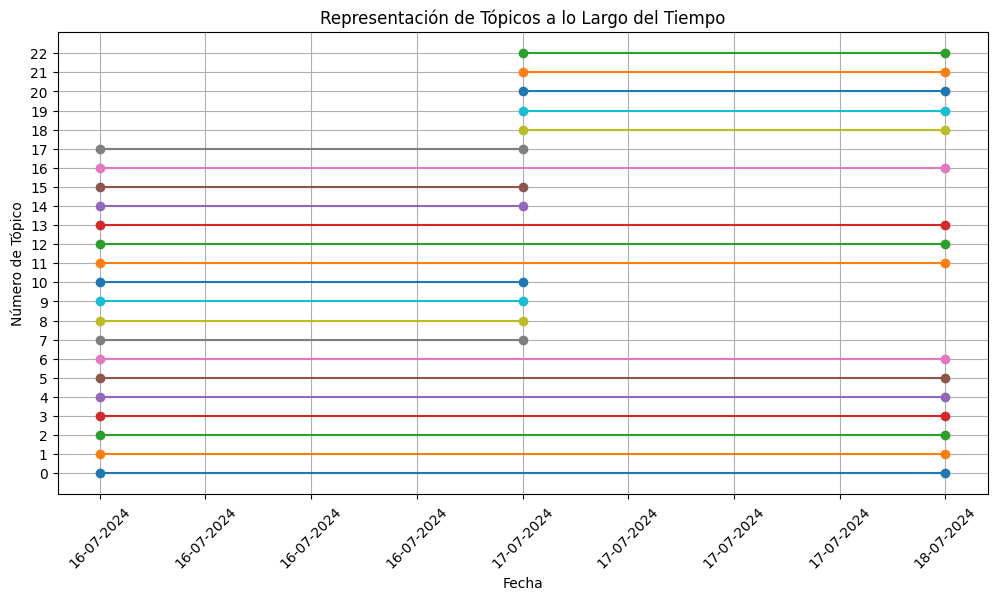

In [33]:
from matplotlib.dates import DateFormatter, AutoDateLocator
import matplotlib.pyplot as plt
import pandas as pd

data_plot = {'topic': range(len(merged_model.get_topics().keys())-1),
             'from': from_date_to_save,
             'to': to_date_to_save}

df_plot = pd.DataFrame(data_plot)
df_plot['from'] = pd.to_datetime(df_plot['from'], format='ISO8601')
df_plot['to'] = pd.to_datetime(df_plot['to'], format='ISO8601')

plt.figure(figsize=(12, 6))

for index, row in df_plot.iterrows():
    plt.plot([row['from'], row['to']], [row['topic'], row['topic']], marker='o')

# Formatear las fechas en el eje X
date_form = DateFormatter("%d-%m-%Y")
plt.gca().xaxis.set_major_formatter(date_form)

# Ajustar los ticks del eje X para que no se repitan las fechas
locator = AutoDateLocator()
plt.gca().xaxis.set_major_locator(locator)

plt.yticks(df_plot['topic'].unique())
plt.xlabel('Fecha')
plt.ylabel('Número de Tópico')
plt.title('Representación de Tópicos a lo Largo del Tiempo')
plt.grid(True)

# Rotar las etiquetas de fecha para mejor legibilidad (opcional)
plt.xticks(rotation=45)

plt.show()


### Panel de Topicos

In [34]:
def panel_topicos(fecha):
    df_topics = pd.DataFrame(get_topics_opensearch(fecha))

    if not df_topics.empty:

        columnas_a_excluir = ['vector', 'created_at', 'best_doc']

        df_query = df_topics[df_topics.columns.difference(columnas_a_excluir)].sort_values("index", ascending=True)
        column_order = ['index','name','from_date', 'to_date', 'similarity_threshold', 'keywords', 'entities', 'id_best_doc', 'title_best_doc']

        df_result = df_query.reindex(columns=column_order).style.set_properties(subset=['name'], **{'text-align': 'left'}).set_table_styles([{'selector': 'th','props': [('min-width', '40px')]},
                                                                                                                                             {'selector': 'td', 'props': [('min-width', '140px')]}])
        
        return df_result
    else:
        print("No hay tópicos para los parámetros elegidos")


In [35]:
fecha = None
fecha = "2024-07-17"
panel_topicos(fecha)

,index,name,from_date,to_date,similarity_threshold,keywords,entities,id_best_doc,title_best_doc
1,7,Regulaciones fiscales y aumentos salariales,2024-07-16T00:00:00,2024-07-17T00:00:00,0.586889,"{'dni terminados': 0.253537938576229, 'julio': 0.08015462139439818}","{'AFIP': 13, 'ANSES': 7, 'Gobierno': 6, 'Milei': 4, 'Argentina': 3, 'Asignaciones Familiares': 3, 'Chesterfield': 3, 'Corrientes': 3, 'DNDA': 3, 'Enzo Fernández': 3}",114805925,Vacaciones con estilo: looks todoterreno para los chicos
0,8,Inversiones y regalías en Argentina,2024-07-16T00:00:00,2024-07-17T00:00:00,0.604881,"{'inversiones': 0.049978426684557466, 'gobernador': 0.04757825334239256, 'planta': 0.04471671343398962, 'proyecto': 0.04455670349055296, 'régimen': 0.04162613129004891}","{'Gobierno': 17, 'Provincia': 14, 'RIGI': 14, 'Río Negro': 14, 'Axel Kicillof': 12, 'Buenos Aires': 12, 'Javier Milei': 12, 'Argentina': 10, 'YPF': 9, 'Alberto Weretilneck': 8}",114875213,Cuándo se concede la incapacidad permanente por falta de sueño: requisitos y cómo solicitarla
2,9,Problemas administrativos en Boca Juniors,2024-07-16T00:00:00,2024-07-17T00:00:00,0.611081,"{'refuerzos': 0.07988269705480892, 'error': 0.06568937847163321, 'jugadores': 0.06293141676138363, 'diferencia horaria': 0.060370832489920305, 'molestia': 0.059528691610870405}","{'Independiente del Valle': 23, 'Diego Martínez': 16, 'Milton Giménez': 16, 'Boca Juniors': 14, 'Boca': 13, 'Brian Aguirre': 11, 'Argentina': 10, 'Gary Medel': 9, 'Milton Delgado': 8, 'Tomás Belmonte': 8}",114851558,Cómo estará el clima en Buenos Aires este martes 16 de julio
3,10,Transformación de clubes deportivos argentinos,2024-07-16T00:00:00,2024-07-17T00:00:00,0.794383,"{'sociedades': 0.23419054855982663, 'sociedades anónimas': 0.19755037522885294, 'asociaciones civiles': 0.1724330947118336}","{'Sociedades Anónimas Deportivas': 25, 'SAD': 21, 'Javier Milei': 19, 'Gobierno': 14, 'AFA': 11, 'República Argentina': 8, 'Cúneo Libarona': 5, 'Mariano Cúneo Libarona': 5, 'Gobierno Nacional': 4, 'IGJ': 3}",114819390,"Victoria Villarruel posteó un sentido mensaje por el deceso de Mauro Testa La Rosa, el piloto de la Fuerza Aérea que sufrió un accidente aéreo en San Luis"
4,14,Eventos y noticias musicales recientes.,2024-07-16T00:00:00,2024-07-17T00:00:00,0.420965,"{'banda': 0.06396417588211072, 'lomitos': 0.05718481926709553, 'pesca': 0.0500976274499703, 'batería': 0.04764948314254812, 'álbum': 0.047001625114929245}","{'Argentina': 4, 'Buenos Aires': 4, 'Tini Stoessel': 3, 'Bautista Mascia': 2, 'Córdoba': 2, 'Galicia': 2, 'Joaquín Sabina': 2, 'Madrid': 2, 'México': 2, 'Paulo Londra': 2}",114850827,Consejo de Mayo: Gobierno comienza a negociar la reforma laboral y política
6,15,Reestructuración de servicios de inteligencia,2024-07-16T00:00:00,2024-07-17T00:00:00,0.862173,"{'inteligencia': 0.22795915244577358, 'agencia': 0.11084316962831665, 'agencias': 0.10521362222449852}","{'Secretaría de Inteligencia': 14, 'AFI': 10, 'SIDE': 9, 'Javier Milei': 8, 'Ministerio de Defensa': 7, 'Presidente Javier Milei': 7, 'SIA': 7, 'Ministerio de Seguridad': 6, 'AFC': 4, 'ASN': 4}",114848234,Costa Rica gana laudo millonario contra minera canadiense
5,17,Presentación de Mbappé en Madrid,2024-07-16T00:00:00,2024-07-17T00:00:00,0.857608,"{'francés': 0.15100163981937653, 'jugador': 0.1493752935113888, 'club': 0.1444268150930548, 'sueño': 0.1375654803783967, 'delantero': 0.11438205589344205}","{'Kylian Mbappé': 11, 'Real Madrid': 11, 'Florentino Pérez': 4, 'estadio Santiago Bernabéu': 4, 'Francia': 2, 'Hala Madrid': 2, 'PSG': 2, 'Selección francesa': 2, 'Argentina': 1, 'Casa Blanca': 1}",114829517,"""Chacarera de ilusión"", un salto de calidad en el nuevo material de Yiyo Cesarone"


### Panel de noticias por topico ( filtrado por umbral del topico y fecha )

In [47]:

def panel_new(topic_id, fecha):
    
    df_topics = pd.DataFrame(get_topics_opensearch(fecha))
    if not df_topics.empty:
        if topic_id in df_topics['index'].tolist() :
            news_results = select_data_from_news(topic=topic_id)
            if fecha in news_results[4]:
                
                data_view = {'ID': news_results[0],
                            'titulo': news_results[1],
                            'estimacion': news_results[3]}

                print(f"Noticias del topico {topic_id}: {df_topics[df_topics['index']==topic_id]['name'].values[0]} | umbral: {df_topics[df_topics['index']==topic_id]['similarity_threshold'].values[0]}")
                df_view = pd.DataFrame(data_view)
                df_view.sort_values('estimacion', ascending=False, inplace=True)
                df_result = df_view[df_view['estimacion'] > df_topics[df_topics['index']==topic_id]['similarity_threshold'].values[0]]
                return df_result
            
            else:
                print("No hay datos para el tópico en esta fecha")
                return
        else:
            print("No hay tópicos para los parámetros elegidos")
            return
    else:
        print("No hay tópicos para los parámetros elegidos")


In [7]:
def panel_news(topic_id, fecha):

    news_results = select_data_from_news(topic=topic_id)
    if news_results:
        if fecha in news_results[4]:
            data_view = {   'ID': news_results[0],
                            'titulo': news_results[1],
                            'estimacion': news_results[3]}
            
            name, threshold = get_one_topic(topic_id)
            print(f"Noticias del topico {topic_id}: <<< {name} >>> | umbral: {threshold}")
            df_view = pd.DataFrame(data_view)
            df_view.sort_values('estimacion', ascending=False, inplace=True)
            df_result = df_view[df_view['estimacion'] > threshold]

            return df_result
        else:
            print("No hay tópicos para los parámetros elegidos")
    else:
        print("No hay tópicos para los parámetros elegidos")

In [12]:
fecha = None
fecha = '2024-07-17'
topic_id = 22
panel_news(topic_id, fecha)


Noticias del topico 22: <<< Creación del Consejo de Mayo >>> | umbral: 0.9124960899353027


,ID,titulo,estimacion
3,114941721,"El Gobierno creó el Consejo de Mayo: objetivos, cómo estará integrado y quién será su presidente",0.937819
8,114916501,"El Gobierno oficializó la creación del Consejo de Mayo, que deberá quedar conformado en un plazo de 30 días",0.933768
6,114943415,El Gobierno oficializó la creación del Consejo de Mayo: cómo estará conformado,0.918811
0,114968198,El Gobierno creó el Consejo de Mayo: conoce los detalles,0.917041
